# Parameterization Tutorial

Here we will see examples on using the `WaveformUncertainty` package to generate and parameterize gravitational waveform differences and then generate waveform uncertainties. You can download this notebook [here](https://github.com/RyanSR71/waveform_uncertainty/blob/main/docs/source/notebooks/Parameterization_Tutorial.ipynb) to run it yourself!

Let's quickly look at the math behind what we are doing here:

The differences between two waveforms are defined in their amplitude difference and their phase difference.

Model amplitude difference is defined as a relative error between the amplitudes of two waveform models:

<h3 align="center">
$\Delta{A}_{\mu}(f;\theta)= \begin{cases} 
    \frac{|\mu_{IMR}(f;\theta)|-|\mu_{EOB}(f;\theta)|}{|\mu_{IMR}(f;\theta)|} & f \leq f_{COR} \\
    \Delta{A}_{\mu}(f_{COR};\theta) & f > f_{COR} 
    \end{cases}$
</h3> 

$f_{COR}$ is the frequency at which the model amplitude difference encounters a discontinuity. At that point, the curve is held constant.
$f_{COR}$ is defined the following way:

<h3 align="center">$\frac{\partial^{2}}{\partial{f}^{2}}\left(\Delta{A}_{\mu}(f_{COR};\theta)\right)=C$</h3> 

where $C$ is our "correction parameter", which is a small negative number that is usually equal to $-10^{-5}$.

Model phase difference can be defined in two ways: raw phase difference and residual phase difference. Raw phase difference is just the difference between the phases of the waveform models. Residual phase difference is the same, but with any overall phase and time shifts removed. 

<h3 align="center">
$\Delta\phi_{\mu}(f;\theta)= \begin{cases} 
      \mathrm{tan}^{-1}\left(\frac{\mathrm{Im}[\mu_{IMR}(f;\theta)]}{\mathrm{Re}[\mu_{IMR}(f;\theta)]}\right)-\mathrm{tan}^{-1}\left(\frac{\mathrm{Im}[\mu_{EOB}(f;\theta)]}{\mathrm{Re}[\mu_{EOB}(f;\theta)]}\right) & f \leq f_{COR} \\
      \Delta\phi_{\mu}(f_{COR};\theta) & f > f_{COR} 
   \end{cases}$
</h3> 

<h3 align="center">
$\Delta\Phi_{\mu}(f;\theta)= \begin{cases} 
      \Delta\phi_{\mu}(f;\theta)-(2\pi{t}_{c}{f}+\phi_{c}) & f \leq f_{COR} \\
      \Delta\Phi_{\mu}(f_{COR};\theta) & f > f_{COR} 
   \end{cases}$
</h3>    

Amplitude and phase uncertainty are defined as the standard deviation of many draws of these waveform differences. In this case, we find the amplitude and phase uncertainties between two models:

<h3 align="center">$\delta{A}_{\mu}(f)=\sqrt{\frac{\sum_{i=1}^{N}\left(\Delta{A}_{\mu}(f;\theta_{i})-\overline{\Delta{A}_{\mu}}(f)\right)}{N}}$</h3>

<h3 align="center">$\delta\Phi_{\mu}(f)=\sqrt{\frac{\sum_{i=1}^{N}\left(\Delta\Phi_{\mu}(f;\theta_{i})-\overline{\Delta\Phi_{\mu}}(f)\right)}{N}}$</h3>

In practice, each array of waveform difference is quite large, and carrying around enough of them to find the uncertainties takes up a lot of space and takes a lot of time to generate. To get around this, we can parameterize the waveform difference arrays (within a small degree of error) as Chebyshev polynomial series. This way, we reduce the amount of data by over 99% and can save and load the data in seconds rather than having to regenerate the waveforms again. Mathematically, this looks like this:

<h3 align="center">
$\Delta{A}_{\mu}(f;\theta)\approx\Delta{A}_{T}(f;a,f_{COR},\Delta{A}_{\mu}(f_{COR};\theta))= \begin{cases} 
      \sum_{i=0}^{N-1}a_{i}T_{i}(f) & f \leq f_{COR} \\
      \Delta{A}_{\mu}(f_{COR};\theta) & f > f_{COR} 
   \end{cases}$
</h3>

<h3 align='center'>
   $\Delta\Phi_{\mu}(f;\theta)\approx\Delta\Phi_{T}(f;b,f_{COR},\Delta\Phi_{\mu}(f_{COR};\theta))= \begin{cases} 
      \sum_{i=0}^{N-1}b_{i}T_{i}(f) & f \leq f_{COR} \\
      \Delta\Phi_{\mu}(f_{COR};\theta) & f > f_{COR} 
   \end{cases}$
</h3>

For more detail, see [Equations and Notation](https://waveformuncertainty.readthedocs.io/en/latest/WFU_Equations.html). Now let's look at the code!

This is everything we need to import to run this tutorial. To run surrogate waveform models later, we will need some extra data to get them to work. We do this by changing the `LAL_DATA_PATH` to a directory that contains the needed files. To get these files yourself, see https://git.ligo.org/lscsoft/lalsuite-extra/. If you are running this on https://jupyter.ligo.caltech.edu/, you can run this directly.

In [32]:
import os
os.environ['LAL_DATA_PATH'] = '/home/ryanmatthew.johnson/lalsuite-extra/data/lalsimulation/'
import numpy as np
import bilby
import matplotlib.pyplot as plt
import sys
import scipy
import lal
import pesummary
from pesummary.gw.file.strain import StrainData
from pesummary.io import read

Here we import the WaveformUncertainty package. Make sure you install the package first! See [Installation](https://waveformuncertainty.readthedocs.io/en/latest/installation.html#installation).

In [31]:
import WaveformUncertainty as wfu


Here we set up a prior with bilby. The values here are based on a GW170817 posterior.

In [11]:
prior = bilby.core.prior.PriorDict()

prior['mass_1'] = bilby.core.prior.Uniform(name='mass_1',latex_label=r'$m_{1}$',minimum=1.37563293,maximum=1.80367393)
prior['mass_2'] = bilby.core.prior.Uniform(name='mass_2',latex_label=r'$m_{2}$',minimum=1.06371259,maximum=1.3758219)
prior['a_1'] = bilby.core.prior.Uniform(name='a_1',latex_label=r'$a_{1}$',minimum=0.0000027020166, maximum=0.04999694)
prior['a_2'] = bilby.core.prior.Uniform(name='a_2',latex_label=r'$a_{2}$',minimum=0.00000212868226, maximum=0.04998414)
prior['luminosity_distance'] = bilby.gw.prior.UniformSourceFrame(name='luminosity_distance',latex_label=r'$d_{L}$',minimum=12.27167145, maximum=52.94141976, unit='Mpc')
prior['phi_12'] = bilby.core.prior.Uniform(name='phi_12',latex_label=r'$\Phi_{12}$',minimum=0.00022415, maximum=6.28307139,boundary='periodic')
prior['phi_jl'] = bilby.core.prior.Uniform(name='phi_jl',latex_label=r'$\Phi_{JL}$',minimum=0.00038279, maximum=6.28301577,boundary='periodic')
prior['tilt_1'] = bilby.core.prior.Uniform(name='tilt_1',latex_label=r'$\theta_{1}$',minimum=0.00465234, maximum=3.12823758, boundary='periodic')
prior['tilt_2'] = bilby.core.prior.Uniform(name='tilt_2',latex_label=r'$\theta_{2}$',minimum=0.01877421, maximum=3.13573364, boundary='periodic')
prior['theta_jn'] = bilby.core.prior.Sine(name='theta_jn',latex_label=r'$\theta_{JN}$')
prior['phase'] = bilby.core.prior.Uniform(name='phase',latex_label=r'$\Phi$',minimum=0.000089295926, maximum=6.2830611, boundary='periodic')
prior['lambda_1'] = bilby.core.prior.Uniform(name="lambda_1",latex_label=r'$\Lambda_{1}$',minimum=0.00147326, maximum=3154.41685213)
prior['lambda_2'] = bilby.core.prior.Uniform(name="lambda_2",latex_label=r'$\Lambda_{2}$',minimum=0.02966776, maximum=4598.76616739)
prior['geocent_time'] = bilby.core.prior.Uniform(name="geocent_time",latex_label=r'$t_{c}$',minimum=1187008882.3, maximum=1187008882.5)
prior['dec'] = bilby.core.prior.DeltaFunction(name='dec',latex_label=r'$\delta$',peak=-0.408084)
prior['ra'] = bilby.core.prior.DeltaFunction(name='ra',latex_label=r'$\alpha_{r}$',peak=3.44616)
prior['psi'] = bilby.core.prior.DeltaFunction(name='psi',latex_label=r'$\Psi$',peak=1.56379256)

We can convert this prior into a dictionary of random samples, which is useful for having a fixed set of samples. Here, we choose 10000.

In [34]:
parameter_data = wfu.parameter_dict_from_prior(prior,10000)

Then, we draw a random sample from the dictionary to be our injection. If we wish to choose which sample we draw, we simply pass `index={your_number}`. Due to the nature of binary neutron star waveform approximants, we assume that we cannot handle precessing spins, but we can handle tides. To change this, pass `precession=True` or `tides=False`.

In [35]:
injection = wfu.injection(parameter_data)

Here we set up our waveform generators with our injection passed as an argument. Because we are looking to generate model differences, we choose two different approximants.

In [36]:
waveform_arguments_1 = dict(waveform_approximant='IMRPhenomPv2_NRTidalv2', reference_frequency=50, 
                            catch_waveform_errors=True, f_low = 20.0, f_high=2048.0)

hf1 = bilby.gw.WaveformGenerator(parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
                    waveform_arguments=waveform_arguments_1,
                    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
                    parameters=injection,
                    sampling_frequency=4096, 
                    duration=256,
                )

waveform_arguments_2 = dict(waveform_approximant='SEOBNRv4T_surrogate', reference_frequency=50, 
                            catch_waveform_errors=True, f_low = 20.0, f_high=2048.0)

hf2 = bilby.gw.WaveformGenerator(parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
                    waveform_arguments=waveform_arguments_2,
                    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
                    parameters=injection,
                    sampling_frequency=4096, 
                    duration=256,
                )

Now that we have our waveform generators, we can calculate the model differences. If we simply pass the waveform generators into the function, it will return model amplitude difference, $\Delta{A}_{\mu}$, and raw model phase difference, $\Delta\phi_{\mu}$. The discontinuity correction frequency, $f_{COR}$, is also returned in the form of the position within the frequency grid where it occurs. We then plot our results.

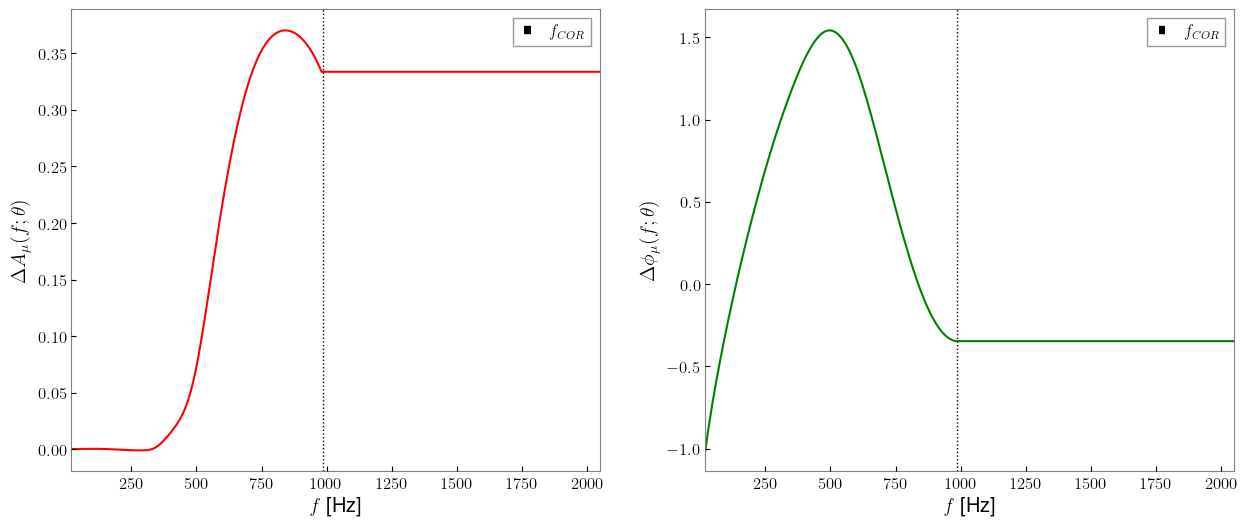

In [37]:
frequency_grid,amplitude_difference,raw_phase_difference,_,_,final_index = wfu.fd_model_difference(hf1,hf2)

fig,ax = plt.subplots(1,2,figsize=(15,6))

ax[0].plot(frequency_grid,amplitude_difference,color='red')
ax[0].axvline(frequency_grid[final_index],color='k',linestyle='dotted',linewidth=1,label=r'$f_{COR}$')
ax[0].set_xlim(frequency_grid[0],frequency_grid[-1])
ax[0].set_xlabel(r'$\mathit{f}$'+" [Hz]")
ax[0].set_ylabel(r'$\Delta{A}_{\mu}(f;\theta)$')
ax[0].tick_params(direction='in')
ax[0].legend()
ax[0].grid(False)

ax[1].plot(frequency_grid,raw_phase_difference,color='green')
ax[1].axvline(frequency_grid[final_index],color='k',linestyle='dotted',linewidth=1,label=r'$f_{COR}$')
ax[1].set_xlim(frequency_grid[0],frequency_grid[-1])
ax[1].set_xlabel(r'$\mathit{f}$'+" [Hz]")
ax[1].set_ylabel(r'$\Delta\phi_{\mu}(f;\theta)$')
ax[1].tick_params(direction='in')
ax[1].legend()
ax[1].grid(False)

plt.show()

Now, let's supply power spectral density (PSD) data. This will return residual model phase difference, $\Delta\Phi_{\mu}$, instead of raw model phase difference.

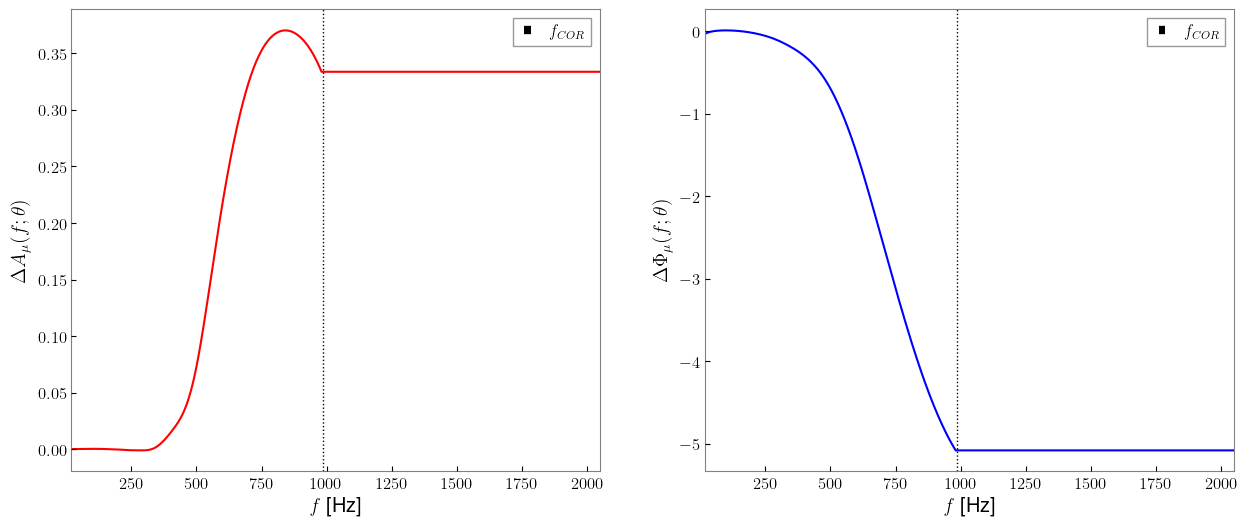

In [38]:
psd_data = np.loadtxt('https://dcc.ligo.org/public/0158/P1900011/001/GWTC1_GW170817_PSDs.dat',comments='#')

frequency_grid,amplitude_difference,residual_phase_difference,_,_,final_index = wfu.fd_model_difference(hf1,hf2,psd_data=psd_data)

fig,ax = plt.subplots(1,2,figsize=(15,6))

ax[0].plot(frequency_grid,amplitude_difference,color='red')
ax[0].axvline(frequency_grid[final_index],color='k',linestyle='dotted',linewidth=1,label=r'$f_{COR}$')
ax[0].set_xlim(frequency_grid[0],frequency_grid[-1])
ax[0].set_xlabel(r'$\mathit{f}$'+" [Hz]")
ax[0].set_ylabel(r'$\Delta{A}_{\mu}(f;\theta)$')
ax[0].tick_params(direction='in')
ax[0].legend()
ax[0].grid(False)

ax[1].plot(frequency_grid,residual_phase_difference,color='blue')
ax[1].axvline(frequency_grid[final_index],color='k',linestyle='dotted',linewidth=1,label=r'$f_{COR}$')
ax[1].set_xlim(frequency_grid[0],frequency_grid[-1])
ax[1].set_xlabel(r'$\mathit{f}$'+" [Hz]")
ax[1].set_ylabel(r'$\Delta\Phi_{\mu}(f;\theta)$')
ax[1].tick_params(direction='in')
ax[1].legend()
ax[1].grid(False)

plt.show()

If we want a large number of draws of waveform differences, we can loop the previous steps. However, each individual set of waveform difference is difficult to carry around as they are just collections of points. We can solve this issue by parameterizing the data as a set of Chebyshev polynomial series and then saving these numbers to a file. This is what the `WaveformUncertainty.parameterization()` function does. We simply pass our approximants, parameter dictionary, and the number of draws we want (as well as optional kwargs). Parameterization will fail if its success rate is lower than `fit_threshold`, which defaults to 75%. Each draw of waveform difference takes about one second to get through, so choosing high `nsamples` values can take up a lot of time. However, choosing low `nsamples` values may cause parameterization to fail.

In [54]:
parameterization=wfu.parameterization("IMRPhenomPv2_NRTidalv2","SEOBNRv4T_surrogate",parameter_data,100,psd_data=psd_data)

Generating Waveform Differences and Parameterizing...
[====================================================================================================] 100.0% 
Done!

Time Elapsed: 100.315 seconds

Parameterized Waveform Model Difference data was created with 100 sample sets at a final parameterization rate of 84.0336%.



The paramerization table can be saved as a `.npy` file with `numpy.save()`. It can then be loaded with `numpy.load()`. To save time, we load a premade file that contains 1000 draws of parameterized waveform differences, `parameterization_nsamples_1000.npy`. To get this file yourself, you can get it [here](https://github.com/RyanSR71/waveform_uncertainty/tree/main/files).

In [56]:
parameterization = np.load('/home/ryanmatthew.johnson/Waveform_Uncertainty/files/parameterization_nsamples_1000.npy',allow_pickle=True)

We can use `WaveformUncertainty.recovery_from_parameterization` to turn the parameterized sets of waveform differences back into the waveform differences they represent. This essentially undoes the parameterization!
From this large set of waveform differences, we can also calculate the means and standard deviations along each frequency point. The standard deviations of waveform model differences are special: they are our waveform uncertainties, $\delta{A}_{\mu}$ and $\delta\Phi_{\mu}$. We can show this on a plot.

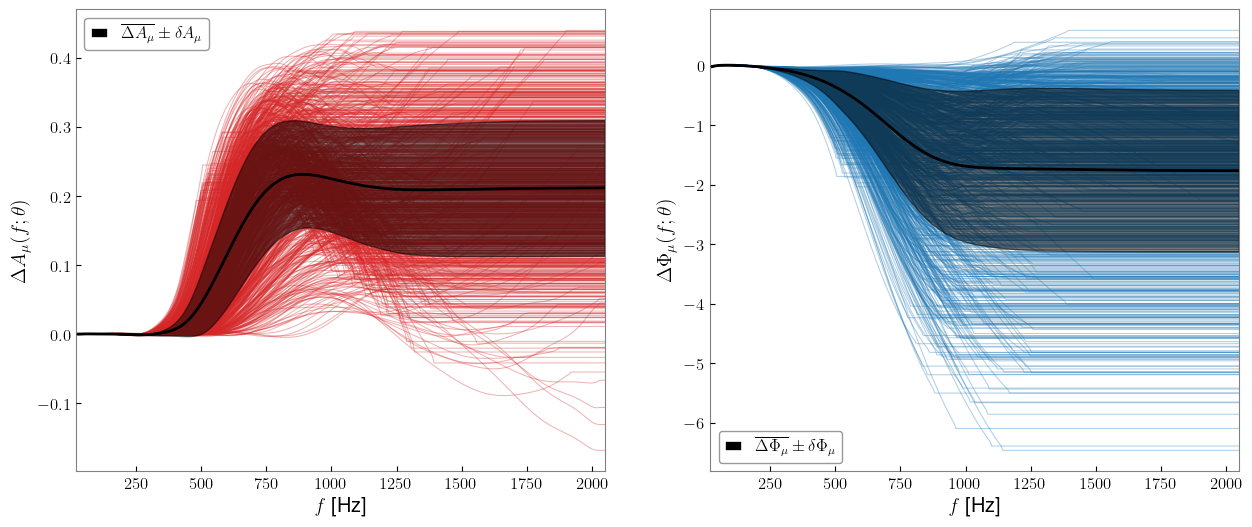

In [57]:
mean_amplitude_difference,amplitude_uncertainty,mean_phase_difference,residual_phase_uncertainty = wfu.uncertainties_from_parameterization(parameterization)

fig,ax = plt.subplots(1,2,figsize=(15,6))

frequency_grid = parameterization[0][1]

for i in range(len(parameterization)):
    # Using __recovery_from_parameterization() to convert the Chebyshev coefficients back into the waveform differences
    ax[0].plot(frequency_grid,wfu.recovery_from_parameterization('amplitude_difference',parameterization[i]),color='tab:red',linewidth=0.75,alpha=0.35,zorder=1)
    ax[1].plot(frequency_grid,wfu.recovery_from_parameterization('phase_difference',parameterization[i]),color='tab:blue',linewidth=0.75,alpha=0.35,zorder=1)

ax[0].plot(frequency_grid,mean_amplitude_difference,color='k',linewidth=2,zorder=2,label=r'$\overline{\Delta{A}_{\mu}}\pm\delta{A}_{\mu}$')
ax[0].fill_between(frequency_grid,mean_amplitude_difference-amplitude_uncertainty,mean_amplitude_difference+amplitude_uncertainty,color='k',alpha=0.5,zorder=2)
ax[0].legend(fancybox=True,loc='upper left')
ax[0].grid(False)
ax[0].set_xlim(frequency_grid[0],frequency_grid[-1])
ax[0].set_xlabel(r'$\mathit{f}$'+" [Hz]")
ax[0].set_ylabel(r'$\Delta{A}_{\mu}(f;\theta)$')
ax[0].tick_params(direction='in')

ax[1].plot(frequency_grid,mean_phase_difference,color='k',linewidth=2,zorder=2,label=r'$\overline{\Delta\Phi_{\mu}}\pm\delta\Phi_{\mu}$')
ax[1].fill_between(frequency_grid,mean_phase_difference-residual_phase_uncertainty,mean_phase_difference+residual_phase_uncertainty,color='k',alpha=0.5,zorder=2)
ax[1].legend(fancybox=True,loc='lower left')
ax[1].grid(False)
ax[1].set_xlim(frequency_grid[0],frequency_grid[-1])
ax[1].set_xlabel(r'$\mathit{f}$'+" [Hz]")
ax[1].set_ylabel(r'$\Delta\Phi_{\mu}(f;\theta)$')
ax[1].tick_params(direction='in')

plt.show()

Thank you for going through this tutorial!